## Part Of Speech Tagging

<img src=https://i.stack.imgur.com/6pdIT.png width=320>

Unlike our previous experience with language modelling, this time around we learn the mapping between two different kinds of elements.

This setting is common for a range of useful problems:
* Speech Recognition - processing human voice into text
* Part Of Speech Tagging - for morphology-aware search and as an auxuliary task for most NLP problems
* Named Entity Recognition - for chat bots and web crawlers
* Protein structure prediction - for bioinformatics

Our current guest is part-of-speech tagging. As the name suggests, it's all about converting a sequence of words into a sequence of part-of-speech tags. We'll use a reduced tag set for simplicity:

### POS-tags
- ADJ - adjective (new, good, high, ...)
- ADP - adposition	(on, of, at, ...)
- ADV - adverb	(really, already, still, ...)
- CONJ	- conjunction	(and, or, but, ...)
- DET - determiner, article	(the, a, some, ...)
- NOUN	- noun	(year, home, costs, ...)
- NUM - numeral	(twenty-four, fourth, 1991, ...)
- PRT -	particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- .	- punctuation marks	(. , ;)
- X	- other	(ersatz, esprit, dunno, ...)

In [1]:
import nltk
import sys
import numpy as np
nltk.download('brown')
nltk.download('universal_tagset')
data = nltk.corpus.brown.tagged_sents(tagset='universal')
all_tags = ['#EOS#','#UNK#','ADV', 'NOUN', 'ADP', 'PRON', 'DET', '.', 'PRT', 'VERB', 'X', 'NUM', 'CONJ', 'ADJ']

data = np.array([ [(word.lower(),tag) for word,tag in sentence] for sentence in data ])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
data[5]

[('it', 'PRON'),
 ('recommended', 'VERB'),
 ('that', 'ADP'),
 ('fulton', 'NOUN'),
 ('legislators', 'NOUN'),
 ('act', 'VERB'),
 ('``', '.'),
 ('to', 'PRT'),
 ('have', 'VERB'),
 ('these', 'DET'),
 ('laws', 'NOUN'),
 ('studied', 'VERB'),
 ('and', 'CONJ'),
 ('revised', 'VERB'),
 ('to', 'ADP'),
 ('the', 'DET'),
 ('end', 'NOUN'),
 ('of', 'ADP'),
 ('modernizing', 'VERB'),
 ('and', 'CONJ'),
 ('improving', 'VERB'),
 ('them', 'PRON'),
 ("''", '.'),
 ('.', '.')]

In [3]:
#from sklearn.cross_validation import train_test_split

from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data,test_size=0.25,random_state=42)

In [4]:
print(type(train_data), train_data.shape)
print(type(test_data), test_data.shape)

<class 'numpy.ndarray'> (43005,)
<class 'numpy.ndarray'> (14335,)


In [5]:
from IPython.display import HTML, display
def draw(sentence):
    words,tags = zip(*sentence)
    display(HTML('<table><tr>{tags}</tr>{words}<tr></table>'.format(
                words = '<td>{}</td>'.format('</td><td>'.join(words)),
                tags = '<td>{}</td>'.format('</td><td>'.join(tags)))))
    
    

draw(data[10])
draw(data[7])

PRON,VERB,ADP,DET,NOUN,.,VERB,NOUN,PRT,VERB,.,DET,NOUN,.,it,urged,that,the,city,``,take,steps,to,remedy,'',this,problem,.


NOUN,VERB,merger,proposed


https://docs.python.org/3/library/functions.html#zip

### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

https://docs.python.org/2/library/collections.html#collections.Counter

In [6]:
from collections import Counter
word_counts = Counter()
for sentence in data:
    words,tags = zip(*sentence)
    word_counts.update(words)

all_words = ['#EOS#','#UNK#']+list(list(zip(*word_counts.most_common(10000)))[0])

#let's measure what fraction of data words are in the dictionary
print("Coverage = {}".format(
                            round(
                                  float(sum(word_counts[w] for w in all_words)) / sum(word_counts.values()),
                                  2)
                            )
)

Coverage = 0.93


In [ ]:
word_counts.values()

https://docs.python.org/2/library/collections.html#collections.defaultdict

In [8]:
from collections import defaultdict
word_to_id = defaultdict(lambda:1,{word:i for i,word in enumerate(all_words)})
tag_to_id = {tag:i for i,tag in enumerate(all_tags)}

convert words and tags into fixed-size matrix:

the max len from the lines is chosen.

tokens from lines are subbed by the ids. 

lines shorter then len_max are complemented by 0s. 

In [9]:
def to_matrix(lines,token_to_id,max_len=None,pad=0,dtype='int32',time_major=False):
    """Converts a list of names into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines),max_len],dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__,lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix

In [10]:
batch_words,batch_tags = zip(*[zip(*sentence) for sentence in data[-3:]])

#print("Word ids:")
#print(to_matrix(batch_words,word_to_id))
print("Tag ids:")
batch_tags_ids = to_matrix(batch_tags,tag_to_id)
print(type(batch_tags_ids))
print(batch_tags_ids.shape)
print(batch_tags_ids)

Tag ids:
<class 'numpy.ndarray'>
(3, 53)
[[ 6  3  4  6  3  3  9  9  7 12  4  5  9  4  6  3 12  7  9  7  9  8  4  6
   3  7  6 13  3  4  6  3  9  4  3  7  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]
 [ 5  9  6  9  3 12  6  3  7  6 13  3  7  6 13  3  7 13  7  5  9  6  3  3
   4  6 13  3  7 12  6  3  6 13  3  7  4  6  3  9  3  7  9  4  6 13  3  9
   6  3  2 13  7]
 [ 4  6  5  9 13  4  3  4  6 13  7 13  3  7  6  3  4  6 13  3  3  9  9  7
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]]


### Build model

We'll focus on a high-level keras interface to recurrent neural networks. It is as simple as you can get with RNN, allbeit somewhat constraining for complex tasks like seq2seq.

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

## Simple RNN

In [11]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.utils as U

__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code as in previous seminar or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [12]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE=32
def generate_batches(sentences,batch_size=BATCH_SIZE,max_len=None,pad=0):
  assert isinstance(sentences,np.ndarray),"Make sure sentences is a numpy array"
    
  while True:
    indices = np.random.permutation(np.arange(len(sentences)))
    for start in range(0,len(indices)-1,batch_size):
        batch_indices = indices[start:start+batch_size]
        batch_words,batch_tags = [],[]
        for sent in sentences[batch_indices]:
            words,tags = zip(*sent)
            batch_words.append(words)
            batch_tags.append(tags)

        batch_words = to_matrix(batch_words,word_to_id,max_len,pad)
        batch_tags = to_matrix(batch_tags,tag_to_id,max_len,pad)

        batch_tags_1hot = to_categorical(batch_tags,len(all_tags)).reshape(batch_tags.shape+(-1,))
            
        #print(batch_tags_1hot.shape)
            
        yield (batch_words, batch_tags_1hot)         

In [ ]:
gen = generate_batches(data[:35]) 
print(gen.__next__())

In [14]:
print(batch_tags_ids.shape)
batch_tags_ids_1hot = to_categorical(batch_tags_ids,len(all_tags))
print(batch_tags_ids_1hot.shape)
print(batch_tags_ids.shape + (-1,))

(3, 53)
(3, 53, 14)
(3, 53, -1)


__Callbacks:__  Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define a custom callback to measure the accuracy of the predicitons.

In [15]:
def compute_test_accuracy(model):
    test_words,test_tags = zip(*[zip(*sentence) for sentence in test_data])
    test_words,test_tags = to_matrix(test_words,word_to_id),to_matrix(test_tags,tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    return float(numerator)/denominator


class EvaluateAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: {}\n".format(acc))
        sys.stdout.flush()
        

In [16]:
K.clear_session()

model = tf.keras.Sequential()
model.add(L.InputLayer([None],dtype='int32'))
model.add(L.Embedding(len(all_words),50))
model.add(L.SimpleRNN(64,return_sequences=True))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(len(all_tags),activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

#keras.utils.plot_model

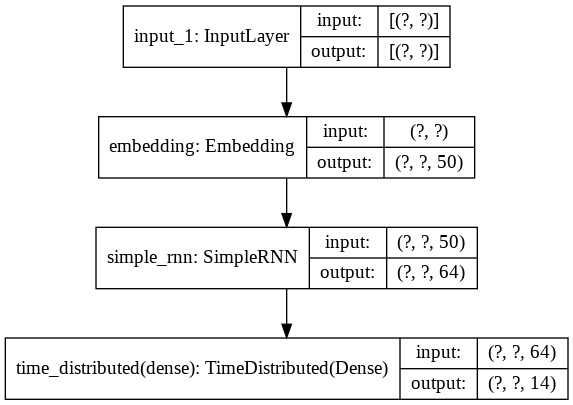

In [17]:
U.plot_model(model, show_shapes = True, expand_nested=True)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          500100    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          7360      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 14)          910       
Total params: 508,370
Trainable params: 508,370
Non-trainable params: 0
_________________________________________________________________


https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

In [19]:
model.compile('adam','categorical_crossentropy')

model.fit( x=generate_batches(train_data), steps_per_epoch = len(train_data)/BATCH_SIZE,
          callbacks=[EvaluateAccuracy()], 
          epochs=5)

Epoch 1/5
1344/1343 [==============================] - ETA: 0s - loss: 0.2421
Measuring validation accuracy...
448/448 [==============================] - 6s 13ms/step

Validation accuracy: 0.9393394820101284

1344/1343 [==============================] - 36s 27ms/step - loss: 0.2421
Epoch 2/5
1342/1343 [============================>.] - ETA: 0s - loss: 0.0582
Measuring validation accuracy...
448/448 [==============================] - 6s 13ms/step

Validation accuracy: 0.9442315703224785

1344/1343 [==============================] - 36s 26ms/step - loss: 0.0583
Epoch 3/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0515
Measuring validation accuracy...
448/448 [==============================] - 6s 13ms/step

Validation accuracy: 0.9455466848441658

1344/1343 [==============================] - 36s 27ms/step - loss: 0.0515
Epoch 4/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0470
Measuring validation accuracy...
448/448 [==============================]

Measure final accuracy on the whole test set.

In [20]:
acc = compute_test_accuracy(model)
print("Final accuracy: {}\n".format(acc))

assert acc>0.94, "Keras has gone on a rampage again."

448/448 [==============================] - 6s 13ms/step
Final accuracy: 0.9454330754744913



In [23]:
draw(test_data[1])

CONJ,PRON,VERB,PRON,VERB,NOUN,NOUN,.,and,you,think,you,have,language,problems,.


### Getting all bidirectional

Since we're analyzing a full sequence, it's legal for us to look into future data.

A simple way to achieve that is to go both directions at once, making a __bidirectional RNN__.

In Keras you can achieve that both manually (using two LSTMs and Concatenate) and by using __`keras.layers.Bidirectional`__. 

This one works just as `TimeDistributed` we saw before: you wrap it around a recurrent layer (SimpleRNN) and it actually creates two layers under the hood.

## Simple RNN Bidirectional

In [24]:
#Define a model that utilizes bidirectional SimpleRNN

K.clear_session()

model2 = tf.keras.Sequential()
model2.add(L.InputLayer([None],dtype='int32'))
model2.add(L.Embedding(len(all_words),50))

# Concatenate(SimpleRNN(inp),SimpleRNN(reverse_inp))
model2.add(L.Bidirectional(L.SimpleRNN(64,return_sequences=True)))
# we can sub SimpleRNN by LSTM or GRU
#model2.add(L.Bidirectional(L.GRU(64,return_sequences=True)))


#add top layer that predicts tag probabilities
stepwise_dense2 = L.Dense(len(all_tags),activation='softmax')
stepwise_dense2 = L.TimeDistributed(stepwise_dense2)
model2.add(stepwise_dense2)

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          500100    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         14720     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 14)          1806      
Total params: 516,626
Trainable params: 516,626
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.compile('adam','categorical_crossentropy')

model2.fit(x = generate_batches(train_data), steps_per_epoch = len(train_data)/BATCH_SIZE,
           callbacks=[EvaluateAccuracy()], 
           epochs=5)

Epoch 1/5
1344/1343 [==============================] - ETA: 0s - loss: 0.2040
Measuring validation accuracy...
448/448 [==============================] - 10s 23ms/step

Validation accuracy: 0.955713002075953

1344/1343 [==============================] - 54s 40ms/step - loss: 0.2040
Epoch 2/5
1344/1343 [==============================] - ETA: 0s - loss: 0.0424
Measuring validation accuracy...
448/448 [==============================] - 10s 22ms/step

Validation accuracy: 0.9605844341392713

1344/1343 [==============================] - 55s 41ms/step - loss: 0.0424
Epoch 3/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0353
Measuring validation accuracy...
448/448 [==============================] - 10s 23ms/step

Validation accuracy: 0.9621439809411676

1344/1343 [==============================] - 54s 40ms/step - loss: 0.0353
Epoch 4/5
1343/1343 [============================>.] - ETA: 0s - loss: 0.0296
Measuring validation accuracy...
448/448 [=============================

In [26]:
acc = compute_test_accuracy(model2)
print("\nFinal accuracy: %.5f"%acc)

assert acc>0.96, "Bidirectional RNNs are better than this!"
print("Well done!")

448/448 [==============================] - 10s 23ms/step

Final accuracy: 0.96056
Well done!
